In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,GRU
from keras import optimizers 
from sklearn.metrics import mean_squared_error

seed = 1234
np.random.seed(seed)
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_raw = pd.read_csv("VNM.csv", index_col="Date", parse_dates=["Date"])
data_raw = data_raw.dropna()

 Count row of data:  988


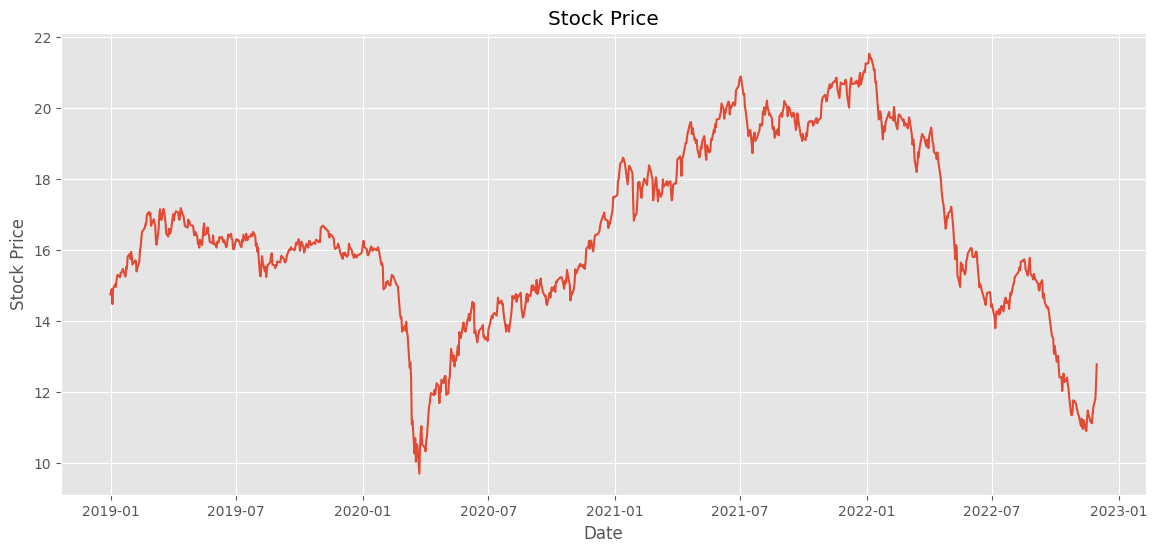

In [3]:
# use feature 'Date' & 'Close'
dataset = pd.DataFrame(data_raw['Close'])
print(' Count row of data: ',len(dataset))

fig = plt.figure(figsize=(14, 6))
plt.plot(dataset)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Stock Price')
plt.show()


In [4]:
#Min-Max Normalization
dataset_norm = dataset.copy()
dataset[['Close']]
scaler = MinMaxScaler()
dataset_norm['Close'] = scaler.fit_transform(dataset[['Close']])
dataset_norm

,Close
Date,
2018-12-31,0.426881
2019-01-02,0.439560
2019-01-03,0.404057
2019-01-04,0.440406
2019-01-07,0.451395
...,...
2022-11-23,0.120034
2022-11-25,0.158073
2022-11-28,0.177515


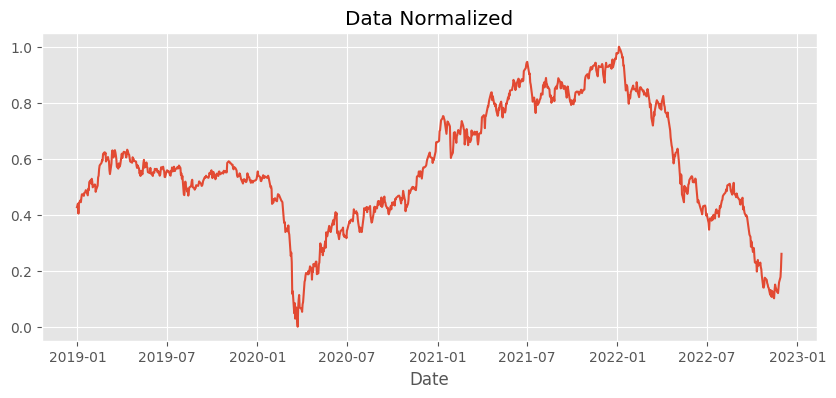

In [5]:

fig = plt.figure(figsize=(10, 4))
plt.plot(dataset_norm)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Normalized')
plt.show()

In [6]:

# Partition data into data train, val & test
totaldata = dataset.values
totaldatatrain = int(len(totaldata)*0.75)
totaldataval = int(len(totaldata)*0.1)
totaldatatest = int(len(totaldata)*0.15)

# Store data into each partition
training_set = dataset_norm[0:totaldatatrain]
val_set=dataset_norm[totaldatatrain:totaldatatrain+totaldataval]
test_set = dataset_norm[totaldatatrain+totaldataval:]

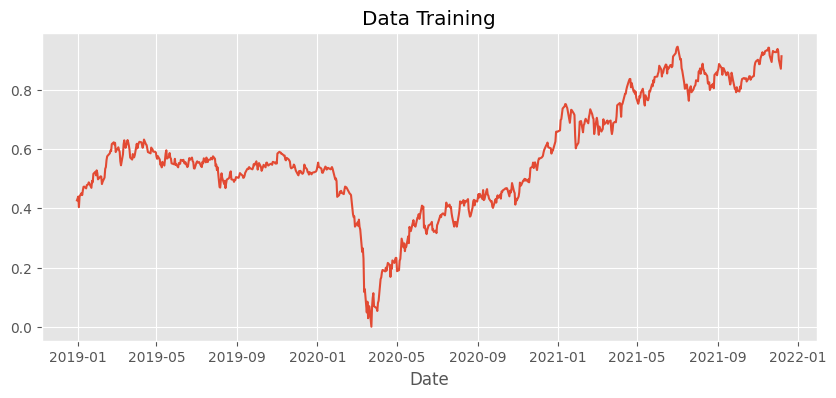

In [7]:
# graph of data training
fig = plt.figure(figsize=(10, 4))
plt.plot(training_set)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Training')
plt.show()

,Close
Date,
2021-12-08,0.929839
2021-12-09,0.942519
2021-12-10,0.928149
2021-12-13,0.928149
2021-12-14,0.928994
...,...
2022-04-22,0.639053
2022-04-25,0.583263
2022-04-26,0.593406


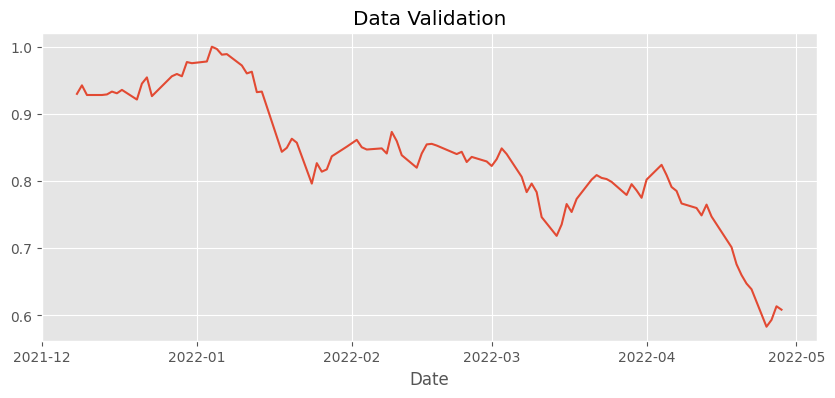

In [8]:
# graph of data validation
fig = plt.figure(figsize=(10, 4))
plt.plot(val_set)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Validation')
val_set

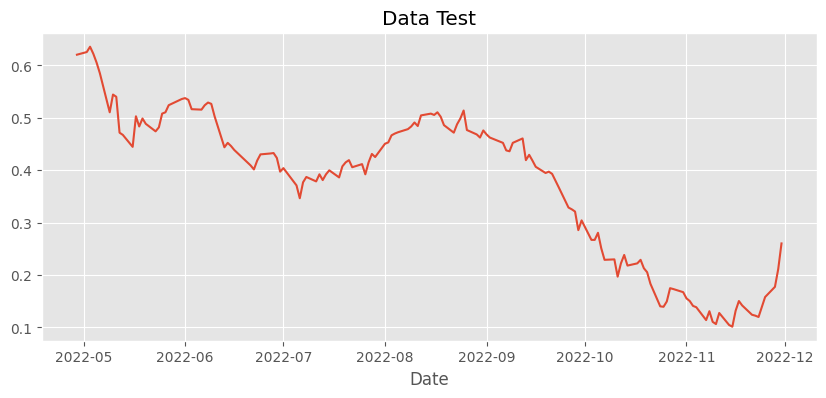

,Close
Date,
2022-04-29,0.620456
2022-05-02,0.625528
2022-05-03,0.635672
2022-05-04,0.622147
2022-05-05,0.605241
...,...
2022-11-23,0.120034
2022-11-25,0.158073
2022-11-28,0.177515


In [9]:
# graph of data test
fig = plt.figure(figsize=(10, 4))
plt.plot(test_set)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Test')
plt.show()
test_set

In [10]:
# Initiaton value of lag
lag = 2
# sliding windows function
def create_sliding_windows(data,len_data,lag):
    x=[]
    y=[]
    for i in range(lag,len_data):
        x.append(data[i-lag:i,0])
        y.append(data[i,0]) 
    return np.array(x),np.array(y)

# Formating data into array for create sliding windows
array_training_set = np.array(training_set)
array_val_set = np.array(val_set)
array_test_set = np.array(test_set)

# Create sliding windows into training data
x_train, y_train = create_sliding_windows(array_training_set,len(array_training_set), lag)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# Create sliding windows into validation data
x_val,y_val = create_sliding_windows(array_val_set,len(array_val_set),lag)
x_val = np.reshape(x_val, (x_val.shape[0],x_val.shape[1],1))
# Create sliding windows into test data
x_test,y_test = create_sliding_windows(array_test_set,len(array_test_set),lag)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [11]:
# Hyperparameters
learning_rate = 0.0001
hidden_unit = 64
batch_size= 32
epoch = 100

# Architecture Gated Recurrent Unit
regressorGRU = Sequential()

# First GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=True, input_shape=(x_train.shape[1],1), activation = 'relu'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=True, activation = 'relu'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=False, activation = 'relu'))
regressorGRU.add(Dropout(0.2))

# Output layer
regressorGRU.add(Dense(units=1))

# Compiling the Gated Recurrent Unit
regressorGRU.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),loss='mean_squared_error')

# Fitting ke data training dan data validation
pred = regressorGRU.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size=batch_size, epochs=epoch)

Epoch 1/100
24/24 [==============================] - 4s 22ms/step - loss: 0.2259 - val_loss: 0.0786
Epoch 2/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0339 - val_loss: 0.0707
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0217 - val_loss: 0.0241
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0120 - val_loss: 0.0056
Epoch 5/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0078 - val_loss: 7.5397e-04
Epoch 6/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0013
Epoch 7/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0066 - val_loss: 0.0014
Epoch 8/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0012
Epoch 9/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 8.8339e-04
Epoch 10/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 9.4658e

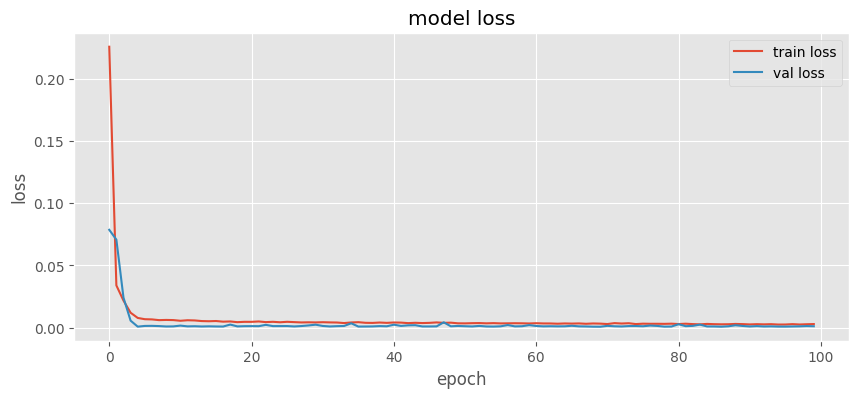

In [12]:
fig = plt.figure(figsize=(10, 4))
plt.plot(pred.history['loss'], label='train loss')
plt.plot(pred.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [13]:
learningrate_parameter = learning_rate
train_loss=pred.history['loss'][-1]
validation_loss=pred.history['val_loss'][-1]
learningrate_parameter=pd.DataFrame(data=[[learningrate_parameter, train_loss, validation_loss]],
                                    columns=['Learning Rate', 'Training Loss', 'Validation Loss'])
learningrate_parameter.set_index('Learning Rate')

,Training Loss,Validation Loss
Learning Rate,,
0.0001,0.002828,0.001062


In [14]:
# Implementation model into data test
y_pred_test = regressorGRU.predict(x_test)

# Invert normalization min-max
y_pred_invert_norm = scaler.inverse_transform(y_pred_test)

5/5 [==============================] - 0s 2ms/step


In [15]:
set_test = dataset["Close"]

In [16]:
# Comparison data test with data prediction
datacompare = pd.DataFrame()
datatest=np.array(set_test[totaldatatrain+totaldataval+lag:])
datapred= y_pred_invert_norm

datacompare['Data Test'] = datatest
datacompare['Prediction Results'] = datapred
datacompare


,Data Test,Prediction Results
0,17.219999,17.092638
1,17.059999,17.184237
2,16.860001,17.194695
3,16.620001,17.005743
4,15.740000,16.776758
...,...,...
142,11.120000,11.227846
143,11.570000,11.213533
144,11.800000,11.272307
145,12.200000,11.553411


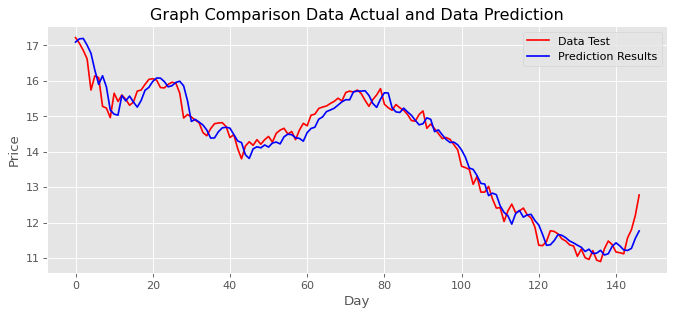

In [17]:
plt.figure(num=None, figsize=(10, 4), dpi=80,facecolor='w', edgecolor='k')
plt.title('Graph Comparison Data Actual and Data Prediction')
plt.plot(datacompare['Data Test'], color='red',label='Data Test')
plt.plot(datacompare['Prediction Results'], color='blue',label='Prediction Results')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

In [18]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
MAPE(datatest, datapred)

13.583143990535742

In [19]:
from sklearn.metrics import mean_squared_error
import math
MSE = mean_squared_error(datatest, datapred)
RMSE = math.sqrt(MSE)
print(RMSE)

0.296440840869085


In [20]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(
    y_true=datatest,
    y_pred=datapred
)

0.22752723402830374